In [137]:
import pathlib
import glob
import os
import collections
import json
from omegaconf import OmegaConf

import pickle
import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')

import pandas as pd
import numpy as np
from einops import rearrange

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from neuroformer.model_neuroformer import GPT, GPTConfig, neuralGPTConfig
from neuroformer.trainer import Trainer, TrainerConfig
from neuroformer.utils import set_seed, update_object, check_common_attrs
from neuroformer.visualize import set_plot_params, set_plot_white
from neuroformer.SpikeVidUtils import round_n, set_intervals
set_plot_params()
set_plot_white()

from scipy import io as scipyio
from scipy.special import softmax
import skimage
import skvideo.io
from scipy.ndimage import gaussian_filter, uniform_filter

parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"
import argparse


In [138]:
def align_trials(df_glm, t_data, key='raw_interval'):
    for i, trial in enumerate(t_data['Trial'].unique()):
        start_interval = t_data[t_data['Trial'] == trial][key].min()
        end_interval = t_data[t_data['Trial'] == trial][key].max()
        # print(start_interval, end_interval, trial)
        df_glm.loc[(df_glm[key] >= start_interval) & (df_glm[key] <= end_interval), 'Trial'] = trial
    return df_glm

In [139]:
from neuroformer.SpikeVidUtils import create_full_trial
from neuroformer.SpikeVidUtils import make_intervals
from neuroformer.analysis import get_rates_trial, calc_corr_psth, get_accuracy, compute_scores

DATASET = "V1_AL"
T_BIN = 0.5

In [140]:
data_path = "./data/Combo3_V1AL/Combo3_V1AL_response.csv"
df = pd.read_csv(data_path)
df['Interval'] = make_intervals(df, T_BIN)

pred_path = "./data/Combo3_V1AL/glm_comparison/pred.csv"
df_pred = pd.read_csv(pred_path)

In [141]:
glm_path = "./data/Combo3_V1AL/combo3neuronGLM.mat"
mat = scipyio.loadmat(glm_path)
df_glm = pd.DataFrame(mat['glmneuron'], columns=['Interval', 'ID', 'Trial']).reset_index(drop=True)
df_glm['Time'] = df_glm['Interval']
df_glm = df_glm.sort_values(by=['Trial', 'Interval']).reset_index(drop=True)
# df_glm = align_trials(df_glm, df_pred, key='Interval')
df_glm['Interval'] = make_intervals(df_glm, T_BIN)
# df_glm[(df_glm['Trial'] > 40) & (df_glm['Trial'] < 58)]['Trial']

In [142]:
# df_glm['Interval'].unique()
print(df_glm[(df_glm['Trial'] > -1) & (df_glm['Trial'] < 20)]['Interval'].unique())
print(df_glm[(df_glm['Trial'] > 19) & (df_glm['Trial'] < 40)]['Interval'].unique())
print(df_glm[(df_glm['Trial'] > 39) & (df_glm['Trial'] < 60)]['Interval'].unique())

[ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.
 14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.
 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.
 28.5 29.  29.5 30.  30.5 31.  31.5 32. ]
[ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.
 14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.
 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.
 28.5 29.  29.5 30.  30.5 31.  31.5 32. ]
[ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.
 14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.
 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.
 28.5 29.  29.5 30.  30.5 31.  31.5 32. ]


In [143]:
# For Trials > 40, add 64 to 'Interval'
df.loc[df['Trial'] > 40, 'Interval'] += 64
df_pred.loc[df_pred['Trial'] > 40, 'Interval'] += 64
df_glm.loc[df_glm['Trial'] > 40, 'Interval'] += 64

# For Trials > 20 and <= 40, add 32 to 'Interval'
mask_20_40 = (df['Trial'] > 20) & (df['Trial'] <= 40)
df.loc[mask_20_40, 'Interval'] += 32

mask_20_40_pred = (df_pred['Trial'] > 20) & (df_pred['Trial'] <= 40)
df_pred.loc[mask_20_40_pred, 'Interval'] += 32

mask_20_40_glm = (df_glm['Trial'] > 20) & (df_glm['Trial'] <= 40)
df_glm.loc[mask_20_40_glm, 'Interval'] += 32


In [144]:
# df_glm = df_glm.sort_values(by=['Trial', 'Interval']).reset_index(drop=True)    
# print(df_glm['Trial'].unique())

In [145]:
len(df_glm['Interval'].unique())

192

In [146]:
trials = df_pred['Trial'].unique()
n_1 = trials + 1
n_2 = trials + 2

In [147]:
from neuroformer.SpikeVidUtils import create_full_trial

df_pred = create_full_trial(df_pred, trials)
df_1 = create_full_trial(df, trials)
df_2 = create_full_trial(df, n_1)
df_3 = create_full_trial(df, n_2)
df_glm = create_full_trial(df_glm, trials)

df_pred['Interval'] = make_intervals(df_pred, T_BIN)
df_1['Interval'] = make_intervals(df_1, T_BIN)
df_2['Interval'] = make_intervals(df_2, T_BIN)
df_3['Interval'] = make_intervals(df_3, T_BIN)

# trim everything to length L
# L = 100
# df_pred = df_pred.iloc[:L]
# df_1 = df_1.iloc[:L]
# df_2 = df_2.iloc[:L]
# df_3 = df_3.iloc[:L]

In [148]:
from neuroformer.analysis import compute_scores, compute_scores_scikit
scores = compute_scores(df_1, df_pred)
scores_scikit = compute_scores_scikit(df_1, df_pred)

scores_glm = compute_scores(df_1, df_glm)
scores_scikit_glm = compute_scores_scikit(df_1, df_glm)

print("Scores")
print("Neuroformer")
print(scores)
print("GLM")
print(scores_glm)

print("Scores Scikit")
print("Neuroformer")
print(scores_scikit)
print("GLM")
print(scores_scikit_glm)

Scores
Neuroformer
defaultdict(<class 'list'>, {'precision': 0.36274508496874064, 'recall': 0.3799959722848725, 'F1': 0.3642538890076514})
GLM
defaultdict(<class 'list'>, {'precision': 0.1393001059321197, 'recall': 0.16928989368382252, 'F1': 0.14995473069257467})
Scores Scikit
Neuroformer
defaultdict(<class 'list'>, {'precision': 0.22622191138188655, 'recall': 0.22659842983059292, 'F1': 0.2222982149731999})
GLM
defaultdict(<class 'list'>, {'precision': 0.07460147602186566, 'recall': 0.08680791064634154, 'F1': 0.07881763648563046})


In [149]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming your dataframes are named 'pred' and 'true'

# Define the number of bins
true = df_1
pred = df_pred

# Bin the 'Interval' values into classes
pred['Interval_pred'] = pd.Categorical(pred['Interval']).codes
true['Interval_true'] = pd.Categorical(true['Interval']).codes

# Merge your dataframes on 'ID' and 'Trial' to align predictions with ground truth
merged_df = pd.merge(pred, true, on=['ID', 'Trial'])

# Then group by 'ID' and 'Trial'
grouped = merged_df.groupby(['ID', 'Trial'])

# Initialize lists to store results
ids = []
trials = []
precisions = []
recalls = []
f1s = []

# For each group, calculate precision, recall, and F1 score
for name, group in grouped:
    id, trial = name
    precision = precision_score(group['Interval_true'], group['Interval_pred'], average='micro')
    recall = recall_score(group['Interval_true'], group['Interval_pred'], average='micro')
    f1 = f1_score(group['Interval_true'], group['Interval_pred'], average='micro')
    
    ids.append(id)
    trials.append(trial)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

# Create a results DataFrame
results = pd.DataFrame({
    'ID': ids,
    'Trial': trials,
    'Precision': precisions,
    'Recall': recalls,
    'F1': f1s
})

mean_results = results.mean()

print(results.mean())


ID           264.497409
Trial          0.000000
Precision      0.027949
Recall         0.027949
F1             0.027949
dtype: float64


In [150]:
print(mean_results)

ID           264.497409
Trial          0.000000
Precision      0.027949
Recall         0.027949
F1             0.027949
dtype: float64


In [151]:
df_pred_full = df_pred

window = 0.5
window_prev = 0.5
window_pred = 0.5
labels = np.array([round(window_pred + window_pred*n, 2) for n in range(0, int(max(df_pred_full['Interval']) / window_pred))])

df_1 = set_intervals(df_1, window, window_prev, window_pred)
df_2 = set_intervals(df_2, window, window_prev, window_pred)
df_3 = set_intervals(df_3, window, window_prev, window_pred)

rates_pred = get_rates_trial(df_pred_full, labels)
rates_1 = get_rates_trial(df_1, labels)
rates_2 = get_rates_trial(df_2, labels)
rates_3 = get_rates_trial(df_3, labels)
rates_glm = get_rates_trial(df_glm, labels)

neurons = df['ID'].unique()
top_corr_pred = calc_corr_psth(rates_pred, rates_1, neurons=neurons)
top_corr_real = calc_corr_psth(rates_1, rates_2, neurons=neurons)
top_corr_real_2 = calc_corr_psth(rates_1, rates_3, neurons=neurons)
top_corr_glm = calc_corr_psth(rates_glm, rates_1, neurons=neurons)

# turn index into ID column
top_corr_pred = top_corr_pred.reset_index()
top_corr_real = top_corr_real.reset_index()
top_corr_glm = top_corr_glm.reset_index()

# rename columns
top_corr_pred = top_corr_pred.rename(columns={'index': 'ID', 0: 'Correlation'})
top_corr_real = top_corr_real.rename(columns={'index': 'ID', 0: 'Correlation'})
top_corr_glm = top_corr_glm.rename(columns={'index': 'ID', 0: 'Correlation'})

In [152]:
stim_intervals = [(0, 32), (32, 64), (64, 96)]


def get_data_for_interval(df, interval):
    """Filter dataframe for a given interval."""
    return df[(df['Interval'] >= interval[0]) & (df['Interval'] < interval[1])]

correlations_by_interval = {}

for interval in stim_intervals:
    # Filter dataframes for current interval
    df_pred_interval = get_data_for_interval(df_pred_full, interval)
    df_1_interval = get_data_for_interval(df_1, interval)
    df_2_interval = get_data_for_interval(df_2, interval)
    df_3_interval = get_data_for_interval(df_3, interval)
    df_glm_interval = get_data_for_interval(df_glm, interval)
    
    # Calculate rates for current interval
    rates_pred_interval = get_rates_trial(df_pred_interval, labels)
    rates_1_interval = get_rates_trial(df_1_interval, labels)
    rates_2_interval = get_rates_trial(df_2_interval, labels)
    rates_3_interval = get_rates_trial(df_3_interval, labels)
    rates_glm_interval = get_rates_trial(df_glm_interval, labels)
    
    # Calculate correlations for current interval
    top_corr_pred_interval = calc_corr_psth(rates_pred_interval, rates_1_interval, neurons=neurons).reset_index().rename(columns={'index': 'ID', 0: 'Correlation'})
    top_corr_real_interval = calc_corr_psth(rates_1_interval, rates_2_interval, neurons=neurons).reset_index().rename(columns={'index': 'ID', 0: 'Correlation'})
    top_corr_real_2_interval = calc_corr_psth(rates_1_interval, rates_3_interval, neurons=neurons).reset_index().rename(columns={'index': 'ID', 0: 'Correlation'})
    top_corr_glm_interval = calc_corr_psth(rates_glm_interval, rates_1_interval, neurons=neurons).reset_index().rename(columns={'index': 'ID', 0: 'Correlation'})
    
    # Store results in dictionary
    correlations_by_interval[interval] = {
        'GLM': top_corr_glm_interval,
        'Neuroformer': top_corr_pred_interval,
        'Real': top_corr_real_interval,
    }

In [153]:
top_corr_glm_interval

,ID,pearson_r,pearson_p
0,472,0.860194,9.244891e-58
1,227,0.631517,7.119759e-23
2,184,0.617013,1.239361e-21
3,193,0.560610,2.286678e-17
4,109,0.541875,4.021149e-16
...,...,...,...
346,261,-0.044876,5.354572e-01
347,90,-0.045397,5.307278e-01
348,471,-0.045708,5.279089e-01
349,383,-0.048460,5.033381e-01


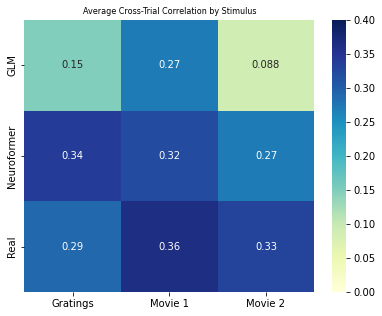

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# set font to Arial
plt.rcParams['font.family'] = 'sans-serif'

# Extract average correlation for each dataset within each interval
data = {
    'Interval': [],
    'Dataset': [],
    'Average Correlation': []
}

for n_stim, (interval, correlation_data) in enumerate(correlations_by_interval.items()):
    for dataset_name, dataset_corr in correlation_data.items():
        data['Interval'].append(str(interval))
        data['Dataset'].append(dataset_name)
        avg_corr = round(dataset_corr['pearson_r'].mean(), 3)
        data['Average Correlation'].append(avg_corr)

df_heatmap = pd.DataFrame(data)

# Pivot the DataFrame to get the required format for the heatmap
df_pivot = df_heatmap.pivot(index='Dataset', columns='Interval', values='Average Correlation')

# Plot the heatmap
plt.figure(figsize=(6.5, 5))
sns.heatmap(df_pivot, annot=True, cmap="YlGnBu", 
            vmin=0, vmax=0.4, cbar_kws={'label': ''})
plt.title("Average Cross-Trial Correlation by Stimulus")
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['Gratings', 'Movie 1', 'Movie 2'])
plt.xlabel("")
plt.ylabel("")
# plt.show()

save_path = "./_rebuttal/V1_AL/corrs"
if not os.path.exists(save_path):
    os.makedirs(save_path)
plt.savefig(os.path.join(save_path, "corrs.pdf"), dpi=300, bbox_inches='tight')


In [155]:
top_corr_glm_interval

,ID,pearson_r,pearson_p
0,472,0.860194,9.244891e-58
1,227,0.631517,7.119759e-23
2,184,0.617013,1.239361e-21
3,193,0.560610,2.286678e-17
4,109,0.541875,4.021149e-16
...,...,...,...
346,261,-0.044876,5.354572e-01
347,90,-0.045397,5.307278e-01
348,471,-0.045708,5.279089e-01
349,383,-0.048460,5.033381e-01


In [28]:
mat_path = "./data/Combo3_V1AL/GLM_GPT_cor.mat"

import scipy.io
corr_mat = scipy.io.loadmat(mat_path)

In [37]:
len(corr_mat['GLM_pred_test_cor'])

386

In [39]:
np.arange(len(corr_mat['GLM_pred_test_cor']))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [56]:
glm_corr_1 = {"ID": np.arange(len(corr_mat['GLM_pred_test_cor'])),
             "pearson_r": corr_mat['GLM_pred_test_cor'][0]}
glm_corr_2 = {"ID": np.arange(len(corr_mat['GLM_pred_test_cor'])),
              "pearson_r": corr_mat['GLM_pred_test_cor'][1]}
glm_corr_3 = {"ID": np.arange(len(corr_mat['GLM_pred_test_cor'])),
                "pearson_r": corr_mat['GLM_pred_test_cor'][2]}

nf_corr_1 = {"ID": np.arange(len(corr_mat['GPT_pred_test_cor'])),
             "pearson_r": corr_mat['GPT_pred_test_cor'][0]}
nf_corr_2 = {"ID": np.arange(len(corr_mat['GPT_pred_test_cor'])),
                "pearson_r": corr_mat['GPT_pred_test_cor'][1]}
nf_corr_3 = {"ID": np.arange(len(corr_mat['GPT_pred_test_cor'])),
                "pearson_r": corr_mat['GPT_pred_test_cor'][2]}

real_corr_1 = {"ID": np.arange(len(corr_mat['data_train_test_cor'])),
               "pearson_r": corr_mat['data_train_test_cor'][0]}
real_corr_2 = {"ID": np.arange(len(corr_mat['data_train_test_cor'])),
                "pearson_r": corr_mat['data_train_test_cor'][1]}
real_corr_3 = {"ID": np.arange(len(corr_mat['data_train_test_cor'])),
                "pearson_r": corr_mat['data_train_test_cor'][2]}

correelations_by_interval_dict = {"GLM": {"1": glm_corr_1, "2": glm_corr_2, "3": glm_corr_3},
                                  "Neuroformer": {"1": nf_corr_1, "2": nf_corr_2, "3": nf_corr_3}}

from scipy.stats import t
import numpy as np

def calculate_p_value(r, n):
    t_statistic = r * np.sqrt((n - 2) / (1 - r**2))
    p_value = 2 * (1 - t.cdf(abs(t_statistic), df=n-2))
    return p_value

def add_p_values(correlation_data):
    for model_name, intervals in correlation_data.items():
        for interval, correlation in intervals.items():
            pearson_r = correlation['pearson_r']
            n = len(pearson_r)
            pearson_p = calculate_p_value(pearson_r, n)
            correlation['pearson_p'] = pearson_p

correlations_by_interval_dict = {"GLM": {"1": glm_corr_1, "2": glm_corr_2, "3": glm_corr_3},
                                 "Neuroformer": {"1": nf_corr_1, "2": nf_corr_2, "3": nf_corr_3},
                                 "Real": {"1": real_corr_1, "2": real_corr_2, "3": real_corr_3}}

add_p_values(correlations_by_interval_dict)

In [162]:
import pandas as pd
import numpy as np

glm_corr_1 = pd.DataFrame({"ID": np.arange(len(corr_mat['GLM_pred_test_cor'])),
                           "pearson_r": corr_mat['GLM_pred_test_cor'][:, 0]})
glm_corr_2 = pd.DataFrame({"ID": np.arange(len(corr_mat['GLM_pred_test_cor'])),
                           "pearson_r": corr_mat['GLM_pred_test_cor'][:, 1]})
glm_corr_3 = pd.DataFrame({"ID": np.arange(len(corr_mat['GLM_pred_test_cor'])),
                           "pearson_r": corr_mat['GLM_pred_test_cor'][:, 2]})

nf_corr_1 = pd.DataFrame({"ID": np.arange(len(corr_mat['GPT_pred_test_cor'])),
                          "pearson_r": corr_mat['GPT_pred_test_cor'][:, 0]})
nf_corr_2 = pd.DataFrame({"ID": np.arange(len(corr_mat['GPT_pred_test_cor'])),
                          "pearson_r": corr_mat['GPT_pred_test_cor'][:, 1]})
nf_corr_3 = pd.DataFrame({"ID": np.arange(len(corr_mat['GPT_pred_test_cor'])),
                          "pearson_r": corr_mat['GPT_pred_test_cor'][:, 2]})

real_corr_1 = pd.DataFrame({"ID": np.arange(len(corr_mat['data_train_test_cor'])),
                            "pearson_r": corr_mat['data_train_test_cor'][:, 0]})
real_corr_2 = pd.DataFrame({"ID": np.arange(len(corr_mat['data_train_test_cor'])),
                            "pearson_r": corr_mat['data_train_test_cor'][:, 1]})
real_corr_3 = pd.DataFrame({"ID": np.arange(len(corr_mat['data_train_test_cor'])),
                            "pearson_r": corr_mat['data_train_test_cor'][:, 2]})

correlations_by_interval_dict = {
    1: {"GLM": glm_corr_1, "Neuroformer": nf_corr_1, "Real": real_corr_1},
    2: {"GLM": glm_corr_2, "Neuroformer": nf_corr_2, "Real": real_corr_2},
    3: {"GLM": glm_corr_3, "Neuroformer": nf_corr_3, "Real": real_corr_3},
}

add_p_values(correlations_by_interval_dict)

{'GLM':       ID  pearson_r  pearson_p
0      0        NaN        NaN
1      1   0.019047   0.709116
2      2        NaN        NaN
3      3   0.197020   0.000098
4      4        NaN        NaN
..   ...        ...        ...
381  381        NaN        NaN
382  382   0.613056   0.000000
383  383   0.121095   0.017304
384  384   0.170369   0.000777
385  385   0.105901   0.037550

[386 rows x 3 columns], 'Neuroformer':       ID  pearson_r     pearson_p
0      0        NaN           NaN
1      1   0.831682  0.000000e+00
2      2        NaN           NaN
3      3   0.664638  0.000000e+00
4      4        NaN           NaN
..   ...        ...           ...
381  381        NaN           NaN
382  382   0.858228  0.000000e+00
383  383   0.576019  0.000000e+00
384  384   0.753289  0.000000e+00
385  385   0.270002  7.129560e-08

[386 rows x 3 columns], 'Real':       ID  pearson_r     pearson_p
0      0  -0.032050  5.301373e-01
1      1   0.862097  0.000000e+00
2      2        NaN           NaN
3  

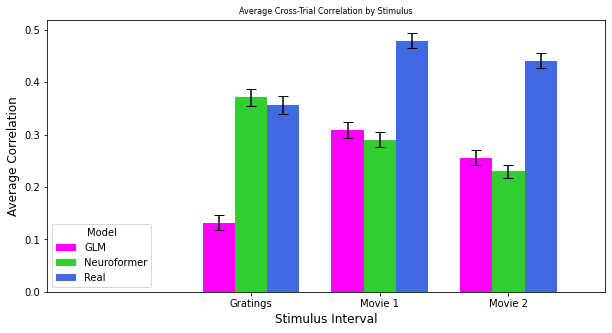

In [163]:
from scipy.stats import ttest_ind, t

# Extract average correlation, and standard deviations for each dataset within each interval
data = {
    'Interval': [],
    'Dataset': [],
    'Average Correlation': [],
}

colors = {
    "Real": 'royalblue',
    "Neuroformer": 'limegreen',  # Vibrant Green
    "GLM": 'magenta',  # Magenta (Fuchsia-like)'
}

glm_neuro_ttest = []
glm_neuro_pvalue = []
glm_neuro_conf_int = []
neuro_real_ttest = []
neuro_real_pvalue = []
neuro_real_conf_int = []
standard_errors = {'GLM': [], 'Neuroformer': [], 'Real': []}


for n_stim, (interval, correlation_data) in enumerate(correlations_by_interval_dict.items()):
    print(correlation_data)
    print(f'Interval: {interval}')
    print(correlation_data)
    for model_name, dataset_corr in correlation_data.items():
        print(data)
        data['Interval'].append(str(interval))
        data['Dataset'].append(model_name)
        avg_corr = round(dataset_corr['pearson_r'].mean(), 3)
        avg_p = dataset_corr['pearson_p']
        data['Average Correlation'].append(avg_corr)
        # data['Average P-value'].append(avg_p)
        corr_values = dataset_corr['pearson_r']
        standard_error = corr_values.std() / np.sqrt(len(corr_values))
        standard_errors[model_name].append(standard_error)
        
        if model_name == 'Neuroformer':
            corr_neur = correlation_data['Neuroformer']['pearson_r']
            corr_glm = correlation_data['GLM']['pearson_r']
            t_stat, p_value = ttest_ind(corr_neur, corr_glm)
            if round(p_value, 3) == 0.0:
                p_value = 0.001
            glm_neuro_ttest.append(t_stat)
            glm_neuro_pvalue.append(p_value)

            # Calculate confidence interval
            confidence_level = 0.95
            degrees_freedom = len(corr_values) - 1
            conf_int = t.interval(confidence_level, degrees_freedom, avg_corr, standard_error)
            glm_neuro_conf_int.append(conf_int)
        
        if model_name == 'Real':
            corr_neur = correlation_data['Neuroformer']['pearson_r']
            corr_real = correlation_data['Real']['pearson_r']
            t_stat, p_value = ttest_ind(corr_real, corr_neur)
            if round(p_value, 3) == 0.0:
                p_value = 0.001
            neuro_real_ttest.append(t_stat)
            neuro_real_pvalue.append(p_value)

            # Calculate confidence interval
            confidence_level = 0.95
            degrees_freedom = len(corr_values) - 1
            conf_int = t.interval(confidence_level, degrees_freedom, avg_corr, standard_error)
            neuro_real_conf_int.append(conf_int)



df_bar = pd.DataFrame(data)
unique_intervals = df_bar['Interval'].unique()


plt.figure(figsize=(10, 5))

# Define the order of the datasets
order = ['GLM', 'Neuroformer', 'Real']

# Number of bars per group
num_bars = len(colors)
offset = 0.4
bar_width = 0.15
group_separation = 0.15  # Space between the groups of bars
bar_positions = np.arange(len(unique_intervals)) * (group_separation + num_bars * bar_width) + offset


# Iterate over the intervals and datasets, plotting each bar
for i, dataset in enumerate(order):
    y_values = df_bar[df_bar['Dataset'] == dataset]['Average Correlation']
    y_err_values = standard_errors[dataset] # Get the corresponding standard errors
    bars = plt.bar(bar_positions + i * bar_width + offset, y_values, width=bar_width, color=colors[dataset], yerr=y_err_values, capsize=5) # Add yerr parameter
    plt.xlim(0, max(bar_positions) + offset + bar_width * 4)

plt.xticks(ticks=bar_positions + offset + bar_width * (num_bars - 1) / 2, labels=['Gratings', 'Movie 1', 'Movie 2'])
plt.title("Average Cross-Trial Correlation by Stimulus")
plt.ylabel('Average Correlation', fontsize=12)
plt.xlabel('Stimulus Interval', fontsize=12)
plt.legend(title='Model', loc='lower left', labels=order)

# Modify the text positioning to place the text between groups of three bars
for i, interval in enumerate(unique_intervals):
    y_pos = df_bar[df_bar['Interval'] == interval]['Average Correlation'].max() + 0.005
    # plt.text(bar_positions[i] + bar_width * (num_bars / 2), y_pos, f't-test GLM-NF p < {glm_neuro_ttest[i]:.3f}', ha='center', bbox=dict(facecolor='white', edgecolor='none', pad=0))
    # plt.text(bar_positions[i] + bar_width * (num_bars / 2), y_pos + 0.005, f't-test Real-NF p < {neuro_real_ttest[i]:.3f}', ha='center', bbox=dict(facecolor='white', edgecolor='none', pad=0))

for dataset_index, dataset in enumerate(order):
    y_values = df_bar[df_bar['Dataset'] == dataset]['Average Correlation']
    y_err_values = standard_errors[dataset]  # Get the corresponding standard errors
    for bar_index, value in enumerate(y_values):
        x_position = bar_positions[bar_index] + dataset_index * bar_width + offset
        y_position = value + y_err_values[bar_index] + 0.002  # Adjust this value if needed to position the text above the error bar
        # plt.text(x_position, y_position, round(value, 2), ha='center', va='bottom', fontsize=9)

save_path = "./_rebuttal/V1_AL/corrs"
if not os.path.exists(save_path):
    os.makedirs(save_path)
plt.savefig(os.path.join(save_path, "corrs_bar.pdf"), dpi=300, bbox_inches='tight')

In [126]:
neuro_real_conf_int

[]

In [ ]:
# glm_neuro_ttest = []
# glm_neuro_pvalue = []
# glm_neuro_conf_int = []
# neuro_real_ttest = []
# neuro_real_pvalue = []
# neuro_real_conf_int = []

glm_neuro_conf_int = np.round(glm_neuro_conf_int, 2)
neuro_real_conf_int = np.round(neuro_real_conf_int, 2)

table_data = {
    ('Grating', '[L, U]'): [glm_neuro_conf_int[0], neuro_real_conf_int[0]],
    ('Grating', 'P value'): [round(glm_neuro_pvalue[0], 3), round(neuro_real_pvalue[0], 3)],
    ('Movie 1', '[L, U]'): [glm_neuro_conf_int[1], neuro_real_conf_int[1]],
    ('Movie 1', 'P value'): [round(glm_neuro_pvalue[1], 3), round(neuro_real_pvalue[1], 3)],
    ('Movie 2', '[L, U]'): [glm_neuro_conf_int[2], neuro_real_conf_int[2]],
    ('Movie 2', 'P value'): [round(glm_neuro_pvalue[2], 3), round(neuro_real_pvalue[2], 3)],
}
ttest_df = pd.DataFrame(table_data)
ttest_df.to_csv('./_rebuttal/V1_AL/ttest_table_2.csv')


In [ ]:
top_corr_pred.mean()

In [ ]:
# # turn index into ID column
# top_corr_pred = top_corr_pred.reset_index()
# top_corr_real = top_corr_real.reset_index()
# top_corr_glm = top_corr_glm.reset_index()

# # rename columns
# top_corr_pred = top_corr_pred.rename(columns={'index': 'ID', 0: 'Correlation'})
# top_corr_real = top_corr_real.rename(columns={'index': 'ID', 0: 'Correlation'})
# top_corr_glm = top_corr_glm.rename(columns={'index': 'ID', 0: 'Correlation'})

In [ ]:
# find duplicate values in IDF

In [ ]:
merged_df

In [ ]:
# Merge dataframes on 'ID'
merged_df = pd.merge(top_corr_pred, top_corr_glm, on=['ID'])

# Create a scatter plot
plt.scatter(merged_df['pearson_r_y'], merged_df['pearson_r_x'], alpha=0.7)

# Add a reference line (y=x) to show where the predicted correlation equals the true correlation
plt.plot(
    [merged_df['pearson_r_y'].min(), merged_df['pearson_r_y'].max()],
    [merged_df['pearson_r_y'].min(), merged_df['pearson_r_y'].max()],
    color='red', linestyle='--'
)

# Add axis labels and a title
plt.xlabel('True Correlation')
plt.ylabel('Predicted Correlation')
plt.title('Predicted vs. True Correlation')

# Show the plot
plt.show()

In [ ]:
top_corr_pred.mean()

In [ ]:
top_ids = top_corr_pred.sort_values(by=['pearson_r'], ascending=False).iloc[:10]
print(top_ids)

In [ ]:
# plot spikes for top 10 neurons
trial_duration = 96
n_intervals = int(trial_duration / window_pred)
intervals = np.array([round(window_pred + window_pred*n, 2) for n in range(0, n_intervals)])

print(intervals)

In [ ]:
glm_path = "./data/Combo3_V1AL/combo3neuronGLM.mat"
mat = scipyio.loadmat(glm_path)
df_glm = pd.DataFrame(mat['glmneuron'], columns=['Interval', 'ID', 'Trial']).reset_index(drop=True)
df_glm['Time'] = df_glm['Interval']
df_glm = df_glm.sort_values(by=['Trial', 'Interval']).reset_index(drop=True)
df_glm = align_trials(df_glm, df_pred, key='Interval')
df_glm['Interval'] = make_intervals(df_glm, T_BIN)

In [ ]:
fig, axes = plt.subplots(20, 1, figsize=(10, 30), sharex=True)  # Create subplots with shared x-axis

for i in range(0, 10):
    neuron_id = top_ids.iloc[i]['ID']
    neuron_pred = df_pred[df_pred['ID'] == neuron_id]
    trials = neuron_pred['Trial'].unique()
    neuron_true = df[(df['ID'] == neuron_id) & (df['Trial'].isin(trials))]
    neuron_pred_times = neuron_pred['Time']
    neuron_true_times = neuron_true['Time']
    neuron_pred = neuron_pred.sort_values(by=['Time'])
    neuron_true = neuron_true.sort_values(by=['Time'])
    
    # Predicted plot on top
    axes[2*i].scatter(neuron_pred['Interval'], neuron_pred['Trial'], color='k', marker='|', label='Predicted')
    axes[2*i].set_xlim([0, 96])  # Setting x limits
    axes[2*i].set_ylabel('Trial', fontsize=13)
    
    # True plot at bottom
    axes[2*i+1].scatter(neuron_true['Interval'], neuron_true['Trial'], color='r', marker='|', label='True')
    axes[2*i+1].set_xlim([0, 96])  # Setting x limits
    axes[2*i+1].set_ylabel('Trial', fontsize=13)

plt.xlabel('Interval', fontsize=15)
plt.suptitle('Neuron Spike Rasters', fontsize=20, y=0.91)  # Main title for all subplots
plt.show()

In [ ]:
df_glm

In [ ]:
fig, axes = plt.subplots(30, 1, figsize=(10, 60), sharex=True)  # Create subplots with shared x-axis

for i in range(0, 10):
    neuron_id = top_ids.iloc[i]['ID']
    neuron_pred = df_pred[df_pred['ID'] == neuron_id]
    neuron_glm_pred = df_glm[df_glm['ID'] == neuron_id]
    trials = neuron_pred['Trial'].unique()
    neuron_true = df[(df['ID'] == neuron_id) & (df['Trial'].isin(trials))]
    neuron_pred_times = neuron_pred['Time']
    neuron_glm_pred_times = neuron_glm_pred['Time']
    neuron_true_times = neuron_true['Time']
    neuron_pred = neuron_pred.sort_values(by=['Time'])
    neuron_glm_pred = neuron_glm_pred.sort_values(by=['Time'])
    neuron_true = neuron_true.sort_values(by=['Time'])

    # Predicted plot on top
    axes[3*i].scatter(neuron_pred['Interval'], neuron_pred['Trial'], color='k', marker='|', label='Predicted')
    axes[3*i].set_xlim([0, 100])  # Setting x limits
    axes[3*i].set_ylabel('Trial', fontsize=13)
    axes[3*i].set_yticks([])  # Disable ytick labels
    axes[3*i].set_yticks(np.linspace(0, neuron_pred['Trial'].max(), 4))  # Keep 4 ticks on the y-axis

    # True plot at bottom
    axes[3*i+2].scatter(neuron_glm_pred['Interval'], neuron_glm_pred['Trial'], color='b', marker='|', label='GLM Predicted')
    axes[3*i+2].set_xlim([0, 100])  # Setting x limits
    axes[3*i+2].set_ylabel('Trial', fontsize=13)
    axes[3*i+2].set_yticks([])  # Disable ytick labels
    axes[3*i+2].set_yticks(np.linspace(0, neuron_glm_pred['Trial'].max(), 4))  # Keep 4 ticks on the y-axis

    # GLM Predicted plot in the middle
    axes[3*i+1].scatter(neuron_true['Interval'], neuron_true['Trial'], color='r', marker='|', label='True')
    axes[3*i+1].set_xlim([0, 100])  # Setting x limits
    axes[3*i+1].set_ylabel('Trial', fontsize=13)
    axes[3*i+1].set_yticks([])  # Disable ytick labels
    axes[3*i+1].set_yticks(np.linspace(0, neuron_true['Trial'].max(), 4))  # Keep 4 ticks on the y-axis

    # Add overarching title
    axes[3*i].set_title('Neuron ID: ' + str(neuron_id), fontsize=15, y=1.05)
    plt.subplots_adjust(hspace=0.5)


# disable all ytick labels
for ax in axes:
    ax.set_yticklabels([])
    ax.set_yticks([])
    
plt.xlabel('Interval', fontsize=15)
plt.suptitle('Neuron Spike Rasters', fontsize=20, y=0.91)  # Main title for all subplots

plt.show()

In [ ]:
plt.figure(figsize=(20, 15))
for i in range(0, 10):
    neuron_id = top_ids.iloc[i]['ID']
    neuron_pred = df_pred[df_pred['ID'] == neuron_id]
    trials = neuron_pred['Trial'].unique()
    neuron_true = df[(df['ID'] == neuron_id) & (df['Trial'].isin(trials))]
    neuron_pred_times = neuron_pred['Time']
    neuron_true_times = neuron_true['Time']
    neuron_pred = neuron_pred.sort_values(by=['Time'])
    neuron_true = neuron_true.sort_values(by=['Time'])
    plt.subplot(5, 2, i+1)  # Displaying 5 rows, 2 columns of plots.
    plt.scatter(neuron_pred['Interval'], neuron_pred['Trial'], color='k', marker='|', label='Predicted')
    plt.scatter(neuron_true['Interval'], neuron_true['Trial'], color='r', marker='|', label='True')
    plt.title('Neuron ID: ' + str(neuron_id), fontsize=15)
    plt.xlabel('Interval', fontsize=13)
    plt.ylabel('Trial', fontsize=13)
    plt.legend()
plt.tight_layout()  # To ensure the subplots do not overlap
plt.suptitle('Neuron Spike Rasters', fontsize=20, y=1.02)  # Main title for all subplots
plt.show()

In [ ]:
plt.figure(figsize=(20, 15))

for i in range(0, 10):
    neuron_id = top_ids.iloc[i]['ID']
    neuron = df_pred[df_pred['ID'] == neuron_id]
    neuron_times = neuron['Time']
    neuron = neuron.sort_values(by=['Time'])
    plt.subplot(5, 2, i+1)  # Displaying 5 rows, 2 columns of plots.
    
    # Define the number of bins to suit your data
    plt.hist2d(neuron['Interval'], neuron['Trial'], bins=[100, 100], cmap='binary')
    
    plt.title('Neuron ID: ' + str(neuron_id), fontsize=15)
    plt.xlabel('Interval', fontsize=13)
    plt.ylabel('Trial', fontsize=13)
    plt.colorbar(label='Number of Spikes')  # Shows the color scale
    
plt.tight_layout()  # To ensure the subplots do not overlap
plt.suptitle('Neuron Spike Histograms', fontsize=20, y=1.02)  # Main title for all subplots
plt.show()

In [ ]:
plt.figure(figsize=(20, 15))

for i in range(0, 10):
    neuron_id = top_ids.iloc[i]['ID']
    neuron = df_pred[df_pred['ID'] == neuron_id]
    neuron_times = neuron['Time']
    neuron = neuron.sort_values(by=['Time'])
    plt.subplot(5, 2, i+1)  # Displaying 5 rows, 2 columns of plots.
    
    # Define the number of bins to suit your data
    plt.hist(neuron['Interval'], bins=100, color='black')
    
    plt.title('Neuron ID: ' + str(neuron_id), fontsize=15)
    plt.xlabel('Interval', fontsize=13)
    plt.ylabel('Number of Spikes', fontsize=13)
    
plt.tight_layout()  # To ensure the subplots do not overlap
plt.suptitle('Neuron Spike Histograms across Intervals', fontsize=20, y=1.02)  # Main title for all subplots
plt.show()